<a href="https://colab.research.google.com/github/souhaib-coder/demandForecastingML/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Charger le fichier Excel
def load_and_clean_data(file_path, sheet_name):
    """
    Loads and performs initial cleaning on the Excel data.

    Args:
        file_path (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to load.

    Returns:
        pandas.DataFrame: The cleaned DataFrame.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(9):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    df = df.drop(columns=[200, "Unnamed: 1", "Unnamed: 5"])
    df = df.T
    df = df.reset_index(drop=True)
    # Convert the date column to datetime, coercing errors
    df[0] = pd.to_datetime(df[0], errors='coerce')
    return df

In [3]:
def convert_data_types(df):
    """Converts columns to appropriate data types."""
    df = df.reset_index(drop=True)

    for col in df.columns:
        if col in ['Code A', 'Gamme']:
            df[col] = df[col].astype(str)
        elif col == 'date':
            df[col] = pd.to_datetime(df[col], errors='coerce')
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [4]:
#methode pour gerer les valeur negatif et merge de vente reelle et prevision
def clean_negative_values(df):
  for i in df.index:
    for column in df.select_dtypes(include=['number']).columns:
      if column != 'Ventes Réelles' and df.loc[i, column] < 0:
          df.loc[i, column] = np.abs(df.loc[i, column])
      elif column == 'Ventes Réelles' and (pd.isna(df.loc[i, column]) or df.loc[i, column] < 0 or (df.loc[i, column] == 0 and df.loc[i,'date'].weekday() != 6)):
          df.loc[i, column] = df.loc[i, 'Prévs']
  df=df.drop(columns='Prévs')
  return df

In [5]:
#Fills missing values
def fill_missing_stock_cv(df):
  """
  Fills missing values in 'Stock Global', 'Stock Agences', 'CV Globale', and 'CV Agences'
  columns using the median grouped by 'Code A'.

  Args:
    df: pandas DataFrame.

  Returns:
    pandas DataFrame with missing values filled.
  """
  for feature in ['Stock Global', 'Stock Agences', 'CV Globale', 'CV Agences','Réalisation','Déblocage']:
      df[feature] = df.groupby('Code A')[feature].transform(
          lambda x: x.fillna(x.median()).infer_objects(copy=False)
      )
  return df

In [6]:
def filter_by_code_a(df):
  """
  Filters the DataFrame to exclude specific 'Code A' values.

  Args:
    df: pandas DataFrame.

  Returns:
    pandas DataFrame with specified 'Code A' values excluded.
  """
  codes_to_exclude = ['FICTIF', 'FICTIF4','FICTIF3','FICTIF2','C3499','C3502']
  df_filtered = df[~df['Code A'].isin(codes_to_exclude)]
  return df_filtered

In [7]:
def pourcentage_nan(df):
  # Nombre total de lignes
  total = len(df)

  # Nombre de NaN par colonne
  nb_nan = df.isna().sum()

  # Pourcentage de NaN par colonne
  pourcentage = (nb_nan / total) * 100
  return pourcentage

In [8]:
def drop_high_nan_columns(df):
  """
  Drops columns with a high percentage of NaN values.

  Args:
    df: pandas DataFrame.

  Returns:
    pandas DataFrame with specified columns dropped.
  """
  # Liste des colonnes à exclure
  #Ces colonnes ont un pourcentage très élevé de valeurs NaN, ce qui est difficile à gérer pour le modèle.
  dic=dict(pourcentage_nan(df))
  colonnes_a_exclure = []
  for column in df.columns:
    if dic[column]>=50:
      colonnes_a_exclure.append(column)
  # Supprimer les colonnes
  df_cleaned = df.drop(columns=colonnes_a_exclure)
  return df_cleaned

In [9]:
def get_Holidays():
  evenements = pd.read_excel('/content/Calendrier_Marocain_2024_2025 (1).xlsx')
  # Étendre les périodes en liste de dates individuelles
  jours_feries_vacances = []

  for lign in evenements.index:
      L=evenements.loc[lign,'Dates'].split(',')
      if len(L) == 1:
          jours_feries_vacances.append(pd.to_datetime(L[0]))
      elif len(L) >= 2:
          start = pd.to_datetime(L[0])
          end = pd.to_datetime(L[-1])
          jours_feries_vacances += list(pd.date_range(start=start, end=end))
  return jours_feries_vacances

# **Traitement des donnees**

***1. Chargement des données***

In [10]:
def filter_product_data(dff):
  """Filters product data based on stock and forecast conditions."""
  for j in dff.index:
    Glo, Age, Pre = dff.loc[j, 'Stock Global'], dff.loc[j, 'Stock Agences'], dff.loc[j, 'Prévs']
    if Glo < 1e-8 or Age < 1e-8 or pd.isna(Pre) or (Pre == 0 and dff.loc[j, 'date'].weekday() != 6 and (dff.loc[j, 'date'] not in get_Holidays())):
      dff = dff.drop(index=j)
  return dff

def process_product_data(df, produit):
  """Processes data for a single product."""
  dff = df.loc[:, df.loc[0] == produit]
  dff = dff.reset_index(drop=True)
  dff_gamme = dff.iloc[1, 1]
  dff.columns = dff.iloc[3]
  dff = dff.drop(index=[0, 1, 2, 3])
  # Étape 1 : Trouver toutes les colonnes nommées "A"
  a_cols = dff.loc[:, dff.columns == 'Fab Prévue']
  # Étape 2 : Faire la somme ligne par ligne
  a_sum = a_cols.sum(axis=1)
  # Étape 3 : Supprimer les colonnes "A" (toutes)
  dff = dff.loc[:, dff.columns != 'Fab Prévue']
  # Étape 4 : Ajouter une nouvelle colonne "A" avec la somme
  dff['Fab Prévue'] = a_sum
  dff['date'] = pd.to_datetime(df.iloc[4:, 0], errors='coerce').dt.date
  dff = dff.dropna(axis=1, how='all')
  dff = dff.reset_index(drop=True)
  dff.insert(0, 'Code A', [produit] * len(dff))
  dff.insert(1, 'Gamme', [dff_gamme] * len(dff))
  dff = filter_product_data(dff) # Call the new filtering function
  return dff

df = load_and_clean_data("/content/Planning Salé 08_07_2025 V12.xlsx", "Planning Fab")
#Chargement des données
row,colums=df.shape
dff=pd.DataFrame()
colonnes = [
    'Code A', 'Stock Global', 'Stock Agences', 'Prévs', 'Réalisation',
    'CV Globale', 'CV Agences', 'Déblocage', 'Ventes Réelles', 'PPED',
    'Ecart Réalisé / Planifié', 'Ecart Ventes / Prévs',
    'Ecart Ventes+PPED / Prévs', 'PSL', 'Fab Prévue', 'date'
]

# Création du DataFrame vide
df_Final = pd.DataFrame(columns=colonnes)
produits=set(df.iloc[0])
produits = {x for x in produits if not pd.isna(x)}- {'Code A'}
for produit in produits:
  dff_processed = process_product_data(df, produit)
  df_Final = pd.concat([df_Final, dff_processed], ignore_index=True)

df_Final = df_Final.iloc[:, :-1]
# Convert the 'date' column to datetime objects, coercing errors
df_Final['date'] = pd.to_datetime(df_Final['date'], errors='coerce')
# Filter out rows where the date is the epoch start or where conversion failed
df_Final = df_Final[(df_Final['date'] != datetime(1970, 1, 1))]
df_Final = convert_data_types(df_Final)

In [11]:
# Récupérer les colonnes dont le minimum est négatif
# Select only numeric columns before calculating the minimum
numeric_cols = df_Final.select_dtypes(include=np.number)
cols_with_negative_min = numeric_cols.loc[:, (numeric_cols.min() < 0)]

# Faire describe uniquement sur ces colonnes
cols_with_negative_min.describe()


,Prévs,CV Globale,CV Agences,Déblocage,Ventes Réelles,Ecart Réalisé / Planifié,Ecart Ventes / Prévs,Ecart Ventes+PPED / Prévs,PSL
count,9.420000e+03,9127.000000,9230.000000,9.385000e+03,4320.000000,9357.000000,4320.000000,3888.000000,3912.000000
mean,6.889204e+04,6.352613,4.017454,1.031896e+05,61273.324674,-1112.209255,-4666.901987,-1548.035846,0.905838
std,9.076221e+04,2.589243,2.020889,1.727274e+05,75476.485104,23499.687985,23123.175556,11518.559344,0.385822
min,-8.584267e+01,-6.889764,-3.937008,-4.038480e+05,-659.000000,-483971.000000,-415956.902284,-230967.000000,-16.910100
25%,1.211036e+04,4.908270,2.794792,0.000000e+00,10371.322664,0.000000,-3577.675909,-1702.445592,0.951167
50%,3.665047e+04,6.279730,3.897540,3.820800e+04,33294.444566,0.000000,0.000000,0.000000,0.981951
75%,9.639692e+04,7.678141,5.031246,1.350640e+05,89299.500000,0.000000,0.000000,0.000000,0.997200
max,1.105981e+06,78.275248,44.728713,2.201972e+06,522825.039166,572408.000000,95175.516783,95175.516783,1.000000


In [12]:
len(df_Final['Code A'].unique())

40

***3.Convertir types de données***

In [27]:
def load_features(data):
  data=df_Final.copy()
  #Convertir types de données
  data=convert_data_types(data)
  #Suppression des produits sans aucune donner exploitables
  data=filter_by_code_a(data)
  #Nettoyage des Valeurs négatives,NaN et fusion de Prevs et Ventes reelle
  data=clean_negative_values(data)
  #Remplissage des colonnes a valeurs manquantes
  data=fill_missing_stock_cv(data)
  #Suppression des colonnes trop vides
  data=drop_high_nan_columns(data)
  #ajout de la colonne 'stock usine'
  data['Stock Usine'] = abs(data['Stock Global'] - data['Stock Agences'])
  data = data.sort_values('date').reset_index(drop=True)
  return data

In [14]:
dfff=load_features(df_Final)

In [15]:
dfff['Code A'].nunique()

35

array([[<Axes: title={'center': 'Stock Global'}>,
        <Axes: title={'center': 'Stock Agences'}>,
        <Axes: title={'center': 'Réalisation'}>],
       [<Axes: title={'center': 'CV Globale'}>,
        <Axes: title={'center': 'CV Agences'}>,
        <Axes: title={'center': 'Déblocage'}>],
       [<Axes: title={'center': 'Ventes Réelles'}>,
        <Axes: title={'center': 'Ecart Réalisé / Planifié'}>,
        <Axes: title={'center': 'Fab Prévue'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Stock Usine'}>, <Axes: >]], dtype=object)

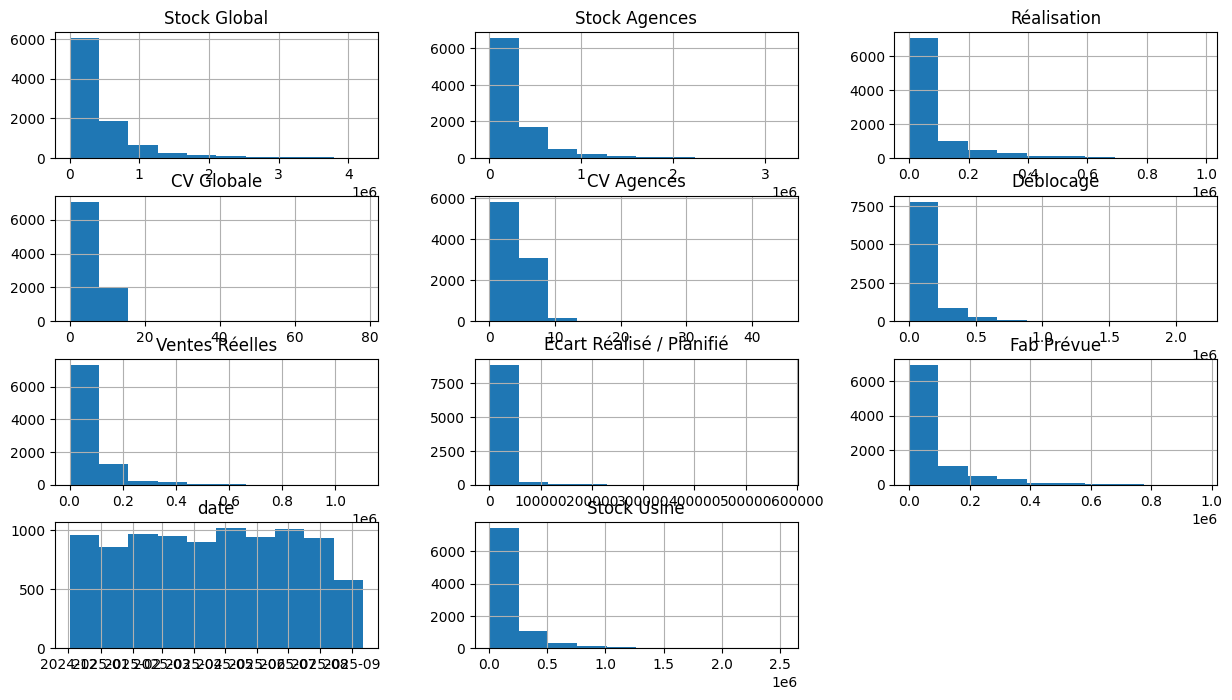

In [16]:
dfff.hist(figsize=(15, 8))

***9.Colonnes de base (année, mois, jour, jour_semaine, etc.)***



In [26]:
def create_date_features(df):
    """Creates date-related features from the 'date' column."""
    df['annee'] = df['date'].dt.year
    df['mois'] = df['date'].dt.month
    df['jour'] = df['date'].dt.day
    df['jour_semaine'] = df['date'].dt.dayofweek  # 0 = lundi, 6 = dimanche
    df['is_weekend'] = df['jour_semaine'].apply(lambda x: 1 if x >= 5 else 0)
    df['trimestre'] = df['date'].dt.quarter

    # 3. Saison spécifique au Maroc
    def get_saison_maroc(mois):
        if mois in [12, 1, 2]:
            return 'Hiver'
        elif mois in [3, 4, 5]:
            return 'Printemps'
        elif mois in [6, 7, 8]:
            return 'Été'
        else:
            return 'Automne'

    df['saison_maroc'] = df['mois'].apply(get_saison_maroc)
    df = pd.get_dummies(df, columns=['saison_maroc'], drop_first=True)

    # 4. Mois de Ramadan pour 2024 et 2025
    ramadan_dates = {
        2024: ('2024-03-11', '2024-04-09'),
        2025: ('2025-03-01', '2025-03-30'),
    }

    def is_ramadan(date):
        year = date.year
        if year in ramadan_dates:
            start, end = pd.to_datetime(ramadan_dates[year])
            return int(start <= date <= end)
        return 0

    df['is_ramadan'] = df['date'].apply(is_ramadan)
    df['is_jour_ferie_ou_vacances'] = df['date'].isin(get_Holidays()).astype(int)
    # We should not drop the date column here as it might be needed later
    # df.drop(columns=['date'], inplace=True)
    return df

# Creation du model de prevision

In [18]:
class AdvancedSalesForecaster:
    """
    Système avancé de prévision de ventes avec optimisation automatique
    et analyse approfondie des performances
    """
    def __init__(self, target_column='Ventes Réelles'):
        self.target_column = target_column
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_score = float('inf')
        self.feature_importance = None
        self.predictions = {}
        self.results_history = []
        self.scaler = None
        self.feature_columns = None
        self.evaluation_metrics = {}

    def prepare_features(self, df):
            """
            Prépare les caractéristiques pour l'entraînement
            """
            print("🔧 PRÉPARATION DES CARACTÉRISTIQUES")
            print("=" * 40)

            # Copie des données
            data = load_features(df)

            # Caractéristiques de lag (décalage temporel)
            target_column = 'Ventes Réelles'
            cols_to_lag = []
            for col in data.columns:
                if data[col].dtype in ['int64', 'float64'] and col != target_column:
                    if data[col].nunique() > 10:
                        cols_to_lag.append(col)
            cols_to_lag.append(target_column)
            for col in cols_to_lag:
                data[f'{col}_lag1'] = data[col].shift(1)
                data[f'{col}_lag2'] = data[col].shift(2)
                data[f'{col}_ma3'] = data[col].rolling(window=3).mean()
                data[f'{col}_ma7'] = data[col].rolling(window=7).mean()
            # Création de caractéristiques temporelles
            data = create_date_features(data)

            # Caractéristiques métier
            data['Stock_Total_Ratio'] = data['Stock Global'] / (data['Stock Agences'] + 1)
            data['CV_Ratio'] = data['CV Globale'] / (data['CV Agences'] + 0.1)
            data['Stock_Efficiency'] = data['Ventes Réelles'] / (data['Stock Global'] + 1)
            data['Production_Gap'] = data['Fab Prévue'] - data['Ecart Réalisé / Planifié']
            data['Stock_Usine_Ratio'] = data['Stock Usine'] / (data['Stock Global'] + 1)
            data['Deblocage_Intensity'] = data['Déblocage'] / (data['Stock Agences'] + 1)



            # Encodage de la gamme si présente
            if 'Gamme' in data.columns:
                gamme_encoded = pd.get_dummies(data['Gamme'], prefix='Gamme')
                data = pd.concat([data, gamme_encoded], axis=1)
             # Encodage de la gamme si présente
            if 'Code A' in data.columns:
                gamme_encoded = pd.get_dummies(data['Code A'], prefix='Code A')
                data = pd.concat([data, gamme_encoded], axis=1)

            for col in data.columns:
                if data[col].dtype == 'bool':
                    data[col] = data[col].astype(int)

            # Suppression des colonnes non numériques
            exclude_cols = ['date', 'Code A', 'Gamme'] + [self.target_column]
            feature_cols = [col for col in data.columns
                          if col not in exclude_cols and data[col].dtype in ['int64', 'float64','int32']]

            # Nettoyage des valeurs manquantes
            data[feature_cols] = data[feature_cols].fillna(data[feature_cols].median())

            self.feature_columns = feature_cols
            print(f"✅ {len(feature_cols)} caractéristiques préparées")

            return data, feature_cols

    def initialize_models(self):
              """
              Initialise une collection étendue de modèles
              """
              self.models = {
                  # Modèles linéaires
                  'Linear_Regression': LinearRegression(),
                  'Ridge': Ridge(alpha=1.0),
                  'Lasso': Lasso(alpha=1.0),
                  'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),

                  # Modèles d'ensemble
                  'Random_Forest': RandomForestRegressor(n_estimators=100, random_state=42),
                  'Extra_Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
                  'Gradient_Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),

                  # Modèles de boosting avancés
                  'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse'),
                  'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),

                  # Autres modèles
                  'SVR': SVR(kernel='rbf'),
                  'KNN': KNeighborsRegressor(n_neighbors=5),
                  'Decision_Tree': DecisionTreeRegressor(random_state=42),
                  'Neural_Network': MLPRegressor(
                      hidden_layer_sizes=(100, 50),
                      max_iter=1000,
                      random_state=42,
                      early_stopping=True
                  )
              }

              print(f"🤖 {len(self.models)} modèles initialisés")
              return self.models


    def split_data(self, data, test_size=0.2, validation_size=0.1):
        """
        Divise les données en respectant l'ordre temporel
        """
        n = len(data)

        # Calcul des indices de division
        val_start = int(n * (1 - test_size - validation_size))
        test_start = int(n * (1 - test_size))

        # Division des données
        train_data = data.iloc[:val_start].copy()
        val_data = data.iloc[val_start:test_start].copy()
        test_data = data.iloc[test_start:].copy()

        print(f"📊 Division des données:")
        print(f"   Entraînement: {len(train_data)} échantillons")
        print(f"   Validation: {len(val_data)} échantillons")
        print(f"   Test: {len(test_data)} échantillons")

        return train_data, val_data, test_data


    def evaluate_model_comprehensive(self, model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
        """
        Évaluation complète d'un modèle avec métriques étendues
        """
        # Entraînement
        model.fit(X_train, y_train)

        # Prédictions
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)

        # Métriques complètes
        metrics = {
            'Model': model_name,

            # Métriques d'entraînement
            'Train_MAE': mean_absolute_error(y_train, y_pred_train),
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'Train_R2': r2_score(y_train, y_pred_train),
            'Train_MAPE': mean_absolute_percentage_error(y_train, y_pred_train) * 100,

            # Métriques de validation
            'Val_MAE': mean_absolute_error(y_val, y_pred_val),
            'Val_RMSE': np.sqrt(mean_squared_error(y_val, y_pred_val)),
            'Val_R2': r2_score(y_val, y_pred_val),
            'Val_MAPE': mean_absolute_percentage_error(y_val, y_pred_val) * 100,

            # Métriques de test
            'Test_MAE': mean_absolute_error(y_test, y_pred_test),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'Test_R2': r2_score(y_test, y_pred_test),
            'Test_MAPE': mean_absolute_percentage_error(y_test, y_pred_test) * 100,

            # Métriques de généralisation
            'Overfit_MAE': mean_absolute_error(y_train, y_pred_train) - mean_absolute_error(y_test, y_pred_test),
            'Overfit_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)) - np.sqrt(mean_squared_error(y_test, y_pred_test))
        }

        # Stockage des prédictions
        self.predictions[model_name] = {
            'train_pred': y_pred_train,
            'val_pred': y_pred_val,
            'test_pred': y_pred_test,
            'train_actual': y_train,
            'val_actual': y_val,
            'test_actual': y_test
        }

        return metrics, model

    def train_all_models(self, data):
        """
        Entraîne tous les modèles avec évaluation complète
        """
        print("\n🏋️ ENTRAÎNEMENT DE TOUS LES MODÈLES")
        print("=" * 50)

        # Préparation des données
        data_processed, feature_cols = self.prepare_features(data)
        train_data, val_data, test_data = self.split_data(data_processed)

        # Extraction des caractéristiques et cible
        X_train = train_data[feature_cols]
        X_val = val_data[feature_cols]
        X_test = test_data[feature_cols]

        y_train = train_data[self.target_column]
        y_val = val_data[self.target_column]
        y_test = test_data[self.target_column]

        # Normalisation des données
        self.scaler = RobustScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Initialisation des modèles
        self.initialize_models()

        results = []
        trained_models = {}

        for name, model in self.models.items():
            print(f"Entraînement de {name}...")
            try:
                # Choix des données (normalisées ou non selon le modèle)
                if name in ['SVR', 'Neural_Network', 'KNN']:
                    X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
                else:
                    X_tr, X_v, X_te = X_train, X_val, X_test

                metrics, trained_model = self.evaluate_model_comprehensive(
                    model, X_tr, X_v, X_te, y_train, y_val, y_test, name
                )

                results.append(metrics)
                trained_models[name] = trained_model

                # Mise à jour du meilleur modèle basé sur Val_RMSE
                if metrics['Val_RMSE'] < self.best_score:
                    self.best_score = metrics['Val_RMSE']
                    self.best_model = trained_model
                    self.best_model_name = name

                print(f"✅ {name} - Val RMSE: {metrics['Val_RMSE']:.2f}, Test RMSE: {metrics['Test_RMSE']:.2f}")

            except Exception as e:
                print(f"❌ Erreur avec {name}: {str(e)}")
                continue

        self.results_df = pd.DataFrame(results)
        self.trained_models = trained_models
        self.data_splits = {
            'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
            'feature_columns': feature_cols
        }

        print(f"\n🏆 Meilleur modèle: {self.best_model_name} (Val RMSE: {self.best_score:.2f})")
        return self.results_df


    def optimize_hyperparameters(self, model_name=None, search_type='random', n_iter=50):
        """
        Optimisation avancée des hyperparamètres
        """
        if model_name is None:
            model_name = self.best_model_name

        print(f"\n⚙️ OPTIMISATION DES HYPERPARAMÈTRES - {model_name}")
        print("=" * 50)

        # Grilles de paramètres étendues
        param_grids = {
            'Random_Forest': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 4, 8],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]
            },
            'XGBoost': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [3, 4, 5, 6, 7],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'subsample': [0.8, 0.85, 0.9, 0.95, 1.0],
                'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1.0],
                'min_child_weight': [1, 3, 5, 7],
                'reg_alpha': [0, 0.1, 0.5, 1],
                'reg_lambda': [0, 0.1, 0.5, 1]
            },
            'LightGBM': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [3, 5, 7, 10, -1],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'subsample': [0.8, 0.85, 0.9, 0.95, 1.0],
                'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1.0],
                'min_child_samples': [5, 10, 20, 30],
                'reg_alpha': [0, 0.1, 0.5, 1],
                'reg_lambda': [0, 0.1, 0.5, 1]
            },
            'Gradient_Boosting': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'SVR': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf', 'poly', 'sigmoid'],
                'epsilon': [0.01, 0.1, 0.2, 0.5]
            },
            'Neural_Network': {
                'hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100), (100, 50, 25)],
                'activation': ['tanh', 'relu'],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate': ['constant', 'adaptive'],
                'learning_rate_init': [0.001, 0.01, 0.1]
            },
            'Ridge': {
                'alpha': [0.1, 1, 10, 100, 1000, 10000]
            },
            'Lasso': {
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        }

        if model_name not in param_grids:
            print(f"Pas d'optimisation disponible pour {model_name}")
            return self.trained_models[model_name]

        # Préparation des données
        X_train = self.data_splits['X_train']
        y_train = self.data_splits['y_train']

        if model_name in ['SVR', 'Neural_Network', 'KNN']:
            X_train = self.scaler.transform(X_train)

        # Choix de la stratégie d'optimisation
        base_model = self.models[model_name]

        if search_type == 'random':
            search = RandomizedSearchCV(
                base_model,
                param_grids[model_name],
                n_iter=n_iter,
                cv=TimeSeriesSplit(n_splits=3),
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            search = GridSearchCV(
                base_model,
                param_grids[model_name],
                cv=TimeSeriesSplit(n_splits=3),
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=1
            )

        search.fit(X_train, y_train)

        print(f"Meilleurs paramètres: {search.best_params_}")
        print(f"Meilleur score CV: {-search.best_score_:.2f}")

        # Test du modèle optimisé
        optimized_model = search.best_estimator_

        # Réévaluation complète
        X_val = self.data_splits['X_val']
        X_test = self.data_splits['X_test']
        y_val = self.data_splits['y_val']
        y_test = self.data_splits['y_test']

        if model_name in ['SVR', 'Neural_Network', 'KNN']:
            X_val = self.scaler.transform(X_val)
            X_test = self.scaler.transform(X_test)

        optimized_metrics, _ = self.evaluate_model_comprehensive(
            optimized_model, X_train, X_val, X_test,
            self.data_splits['y_train'], y_val, y_test,
            f"{model_name}_Optimized"
        )

        print(f"Performance après optimisation:")
        print(f"  Val RMSE: {optimized_metrics['Val_RMSE']:.2f}")
        print(f"  Test RMSE: {optimized_metrics['Test_RMSE']:.2f}")
        print(f"  Test R²: {optimized_metrics['Test_R2']:.3f}")

        # Mise à jour si meilleur
        if optimized_metrics['Val_RMSE'] < self.best_score:
            self.best_model = optimized_model
            self.best_model_name = f"{model_name}_Optimized"
            self.best_score = optimized_metrics['Val_RMSE']
            print("🏆 Nouveau meilleur modèle!")

        return optimized_model, optimized_metrics

    def analyze_feature_importance(self, top_n=15):
        """
        Analyse avancée de l'importance des caractéristiques

        """
        print(f"\n📊 ANALYSE DE L'IMPORTANCE DES CARACTÉRISTIQUES (Top {top_n})")
        print("=" * 65)

        importances = {}

        # Importance basée sur le modèle (si disponible)
        if hasattr(self.best_model, 'feature_importances_'):
            model_importance = pd.DataFrame({
                'Feature': self.data_splits['feature_columns'],
                'Model_Importance': self.best_model.feature_importances_
            }).sort_values('Model_Importance', ascending=False)

            importances['model'] = model_importance
            print("Top caractéristiques selon le modèle:")
            print(model_importance.head(top_n))

        # Importance par permutation
        X_test = self.data_splits['X_test']
        y_test = self.data_splits['y_test']

        if self.best_model_name in ['SVR', 'Neural_Network', 'KNN']:
            X_test = self.scaler.transform(X_test)

        perm_importance = permutation_importance(
            self.best_model, X_test, y_test,
            n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error'
        )

        perm_importance_df = pd.DataFrame({
            'Feature': self.data_splits['feature_columns'],
            'Perm_Importance': perm_importance.importances_mean,
            'Perm_Std': perm_importance.importances_std
        }).sort_values('Perm_Importance', ascending=False)

        importances['permutation'] = perm_importance_df
        print(f"\nTop caractéristiques par permutation:")
        print(perm_importance_df.head(top_n))

        self.feature_importance = importances
        return importances
    def plot_comprehensive_results(self, figsize=(20, 15)):
        """
        Visualisations complètes des résultats
        """
        fig, axes = plt.subplots(3, 4, figsize=figsize)
        fig.suptitle('Analyse Complète des Modèles de Prévision de Ventes', fontsize=16, fontweight='bold')

        # 1. Comparaison RMSE
        ax1 = axes[0, 0]
        models_comp = self.results_df.set_index('Model')[['Val_RMSE', 'Test_RMSE']]
        models_comp.plot(kind='bar', ax=ax1, rot=45)
        ax1.set_title('Comparaison RMSE')
        ax1.set_ylabel('RMSE')
        ax1.legend()

        # 2. Comparaison R²
        ax2 = axes[0, 1]
        r2_comp = self.results_df.set_index('Model')[['Val_R2', 'Test_R2']]
        r2_comp.plot(kind='bar', ax=ax2, rot=45)
        ax2.set_title('Comparaison R² Score')
        ax2.set_ylabel('R² Score')
        ax2.legend()

        # 3. Analyse du surapprentissage
        ax3 = axes[0, 2]
        overfitting = self.results_df.set_index('Model')['Overfit_RMSE']
        colors = ['green' if x <= 0 else 'red' for x in overfitting]
        overfitting.plot(kind='bar', ax=ax3, color=colors, rot=45)
        ax3.set_title('Analyse du Surapprentissage')
        ax3.set_ylabel('Différence RMSE (Train - Test)')
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7)

        # 4. MAPE Comparison
        ax4 = axes[0, 3]
        mape_comp = self.results_df.set_index('Model')[['Val_MAPE', 'Test_MAPE']]
        mape_comp.plot(kind='bar', ax=ax4, rot=45)
        ax4.set_title('Comparaison MAPE (%)')
        ax4.set_ylabel('MAPE (%)')
        ax4.legend()

        # 5. Prédictions vs Réalité (meilleur modèle)
        ax5 = axes[1, 0]
        best_pred = self.predictions[self.best_model_name]
        ax5.scatter(best_pred['test_actual'], best_pred['test_pred'], alpha=0.7, color='blue')
        min_val = min(best_pred['test_actual'].min(), best_pred['test_pred'].min())
        max_val = max(best_pred['test_actual'].max(), best_pred['test_pred'].max())
        ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax5.set_xlabel('Valeurs Réelles')
        ax5.set_ylabel('Prédictions')
        ax5.set_title(f'Prédictions vs Réalité - {self.best_model_name}')

        # 6. Analyse des résidus
        ax6 = axes[1, 1]
        residuals = best_pred['test_actual'] - best_pred['test_pred']
        ax6.scatter(best_pred['test_pred'], residuals, alpha=0.7, color='orange')
        ax6.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax6.set_xlabel('Prédictions')
        ax6.set_ylabel('Résidus')
        ax6.set_title('Analyse des Résidus')

        # 7. Distribution des résidus
        ax7 = axes[1, 2]
        residuals.hist(bins=20, ax=ax7, alpha=0.7, color='green', edgecolor='black')
        ax7.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {residuals.mean():.2f}')
        ax7.set_xlabel('Résidus')
        ax7.set_ylabel('Fréquence')
        ax7.set_title('Distribution des Résidus')
        ax7.legend()

        # 8. Q-Q Plot des résidus
        ax8 = axes[1, 3]
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=ax8)
        ax8.set_title('Q-Q Plot des Résidus')

        # 9. Importance des caractéristiques
        ax9 = axes[2, 0]
        if self.feature_importance and 'permutation' in self.feature_importance:
            top_features = self.feature_importance['permutation'].head(10)
            bars = ax9.barh(range(len(top_features)), top_features['Perm_Importance'])
            ax9.set_yticks(range(len(top_features)))
            ax9.set_yticklabels(top_features['Feature'])
            ax9.set_xlabel('Importance par Permutation')
            ax9.set_title('Top 10 Caractéristiques')

            # Couleurs selon l'importance
            for i, bar in enumerate(bars):
                if i < 3:  # Top 3 en rouge
                    bar.set_color('red')
                elif i < 6:  # 4-6 en orange
                    bar.set_color('orange')
                else:  # Autres en bleu
                    bar.set_color('blue')

        # 10. Évolution temporelle des prédictions
        ax10 = axes[2, 1]
        if len(best_pred['test_actual']) > 1:
            test_indices = range(len(best_pred['test_actual']))
            ax10.plot(test_indices, best_pred['test_actual'], 'b-', label='Réel', linewidth=2)
            ax10.plot(test_indices, best_pred['test_pred'], 'r--', label='Prédit', linewidth=2)
            ax10.set_xlabel('Index Temporel')
            ax10.set_ylabel('Ventes')
            ax10.set_title('Évolution Temporelle des Prédictions')
            ax10.legend()
            ax10.grid(True, alpha=0.3)

        # 11. Erreurs absolues par prédiction
        ax11 = axes[2, 2]
        abs_errors = np.abs(best_pred['test_actual'] - best_pred['test_pred'])
        ax11.plot(range(len(abs_errors)), abs_errors, 'ro-', alpha=0.7)
        ax11.axhline(abs_errors.mean(), color='green', linestyle='--', linewidth=2,
                    label=f'Erreur moyenne: {abs_errors.mean():.2f}')
        ax11.set_xlabel('Index de Prédiction')
        ax11.set_ylabel('Erreur Absolue')
        ax11.set_title('Erreurs par Prédiction')
        ax11.legend()
        ax11.grid(True, alpha=0.3)

        # 12. Performance par métrique
        ax12 = axes[2, 3]
        best_metrics = self.results_df[self.results_df['Model'] == self.best_model_name].iloc[0]
        metrics_to_show = ['Test_MAE', 'Test_RMSE', 'Test_MAPE']
        metric_values = [best_metrics[m] for m in metrics_to_show]
        metric_labels = ['MAE', 'RMSE', 'MAPE (%)']

        bars = ax12.bar(metric_labels, metric_values, color=['skyblue', 'lightcoral', 'lightgreen'])
        ax12.set_title(f'Métriques du Meilleur Modèle\n{self.best_model_name}')
        ax12.set_ylabel('Valeur')

        # Ajout des valeurs sur les barres
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax12.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                     f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        return fig

    def generate_prediction_report(self):
        """
        Génère un rapport détaillé des performances
        """
        print("\n📋 RAPPORT DÉTAILLÉ DES PERFORMANCES")
        print("=" * 50)

        # Résumé du meilleur modèle
        best_metrics = self.results_df[self.results_df['Model'] == self.best_model_name].iloc[0]

        print(f"🏆 MEILLEUR MODÈLE: {self.best_model_name}")
        print("-" * 30)
        print(f"📊 Métriques de Test:")
        print(f"   • RMSE: {best_metrics['Test_RMSE']:.2f}")
        print(f"   • MAE: {best_metrics['Test_MAE']:.2f}")
        print(f"   • R²: {best_metrics['Test_R2']:.3f}")
        print(f"   • MAPE: {best_metrics['Test_MAPE']:.1f}%")

        print(f"\n📈 Métriques de Validation:")
        print(f"   • RMSE: {best_metrics['Val_RMSE']:.2f}")
        print(f"   • MAE: {best_metrics['Val_MAE']:.2f}")
        print(f"   • R²: {best_metrics['Val_R2']:.3f}")
        print(f"   • MAPE: {best_metrics['Val_MAPE']:.1f}%")

        # Analyse du surapprentissage
        overfit_rmse = best_metrics['Overfit_RMSE']
        if overfit_rmse <= 0:
            overfit_status = "✅ Pas de surapprentissage détecté"
        elif overfit_rmse <= 10:
            overfit_status = "⚠️ Léger surapprentissage"
        else:
            overfit_status = "❌ Surapprentissage significatif"

        print(f"\n🔍 Analyse du Surapprentissage:")
        print(f"   • Différence RMSE (Train-Test): {overfit_rmse:.2f}")
        print(f"   • Status: {overfit_status}")

        # Classement des modèles
        print(f"\n🥇 CLASSEMENT DES MODÈLES (par Val_RMSE):")
        print("-" * 35)
        top_models = self.results_df.nsmallest(5, 'Val_RMSE')[['Model', 'Val_RMSE', 'Test_RMSE', 'Test_R2']]
        for idx, (_, row) in enumerate(top_models.iterrows(), 1):
            emoji = ["🥇", "🥈", "🥉", "4️⃣", "5️⃣"][idx-1]
            print(f"{emoji} {row['Model']}: Val RMSE={row['Val_RMSE']:.2f}, Test RMSE={row['Test_RMSE']:.2f}, R²={row['Test_R2']:.3f}")

        # Top caractéristiques
        if self.feature_importance and 'permutation' in self.feature_importance:
            print(f"\n🎯 TOP 5 CARACTÉRISTIQUES LES PLUS IMPORTANTES:")
            print("-" * 45)
            top_features = self.feature_importance['permutation'].head(5)
            for idx, (_, row) in enumerate(top_features.iterrows(), 1):
                print(f"{idx}. {row['Feature']}: {row['Perm_Importance']:.4f} ± {row['Perm_Std']:.4f}")

        # Recommandations
        print(f"\n💡 RECOMMANDATIONS:")
        print("-" * 20)

        if best_metrics['Test_R2'] > 0.8:
            print("✅ Excellentes performances de prédiction")
        elif best_metrics['Test_R2'] > 0.6:
            print("✅ Bonnes performances de prédiction")
        else:
            print("⚠️ Performances limitées - envisager plus de données ou de caractéristiques")

        if best_metrics['Test_MAPE'] < 10:
            print("✅ Très faible erreur relative")
        elif best_metrics['Test_MAPE'] < 20:
            print("✅ Erreur relative acceptable")
        else:
            print("⚠️ Erreur relative élevée - vérifier la qualité des données")

        if overfit_rmse > 10:
            print("⚠️ Réduire la complexité du modèle ou augmenter les données d'entraînement")

        return {
            'best_model': self.best_model_name,
            'best_metrics': best_metrics.to_dict(),
            'top_models': top_models.to_dict('records'),
            'overfit_analysis': {'rmse_diff': overfit_rmse, 'status': overfit_status}
        }

    def predict_future_sales(self, new_data, confidence_level=0.95):
        """
        Prédictions avec intervalles de confiance
        """
        print("\n🔮 PRÉDICTION DE VENTES FUTURES")
        print("=" * 35)

        if isinstance(new_data, dict):
            new_data = pd.DataFrame([new_data])

        # Préparation des nouvelles données
        processed_data, _ = self.prepare_features(new_data)
        X_new = processed_data[self.feature_columns].fillna(0)

        # Normalisation si nécessaire
        if self.best_model_name in ['SVR', 'Neural_Network', 'KNN']:
            X_new_scaled = self.scaler.transform(X_new)
            prediction = self.best_model.predict(X_new_scaled)
        else:
            prediction = self.best_model.predict(X_new)

        # Calcul de l'intervalle de confiance basé sur les erreurs de validation
        residuals = (self.predictions[self.best_model_name]['test_actual'] -
                    self.predictions[self.best_model_name]['test_pred'])
        residual_std = np.std(residuals)

        # Facteur pour l'intervalle de confiance
        from scipy import stats
        t_factor = stats.t.ppf((1 + confidence_level) / 2, len(residuals) - 1)
        margin_error = t_factor * residual_std

        results = []
        for i, pred in enumerate(prediction):
            result = {
                'prediction': pred,
                'lower_bound': pred - margin_error,
                'upper_bound': pred + margin_error,
                'confidence_level': confidence_level,
                'margin_error': margin_error,
                'model_used': self.best_model_name
            }
            results.append(result)

            print(f"Prédiction {i+1}:")
            print(f"  • Ventes prédites: {pred:.0f} unités")
            print(f"  • Intervalle {int(confidence_level*100)}%: [{pred-margin_error:.0f}, {pred+margin_error:.0f}]")
            print(f"  • Marge d'erreur: ±{margin_error:.0f}")

        return results if len(results) > 1 else results[0]

    def save_complete_model(self, filepath='advanced_sales_forecasting_model.joblib'):
        """
        Sauvegarde complète du système de prévision
        """
        model_package = {
            'best_model': self.best_model,
            'best_model_name': self.best_model_name,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns,
            'feature_importance': self.feature_importance,
            'results_df': self.results_df,
            'predictions': self.predictions,
            'best_score': self.best_score,
            'target_column': self.target_column,
            'trained_models': getattr(self, 'trained_models', {}),
            'data_splits': getattr(self, 'data_splits', {}),
            'creation_date': datetime.now().isoformat()
        }

        joblib.dump(model_package, filepath)
        print(f"💾 Système complet sauvegardé dans: {filepath}")
        print(f"📊 Contenu: modèle, scaler, caractéristiques, résultats et métriques")

        return filepath

    def load_complete_model(self, filepath):
        """
        Charge un système de prévision complet
        """
        model_package = joblib.load(filepath)

        self.best_model = model_package['best_model']
        self.best_model_name = model_package['best_model_name']
        self.scaler = model_package['scaler']
        self.feature_columns = model_package['feature_columns']
        self.feature_importance = model_package['feature_importance']
        self.results_df = model_package['results_df']
        self.predictions = model_package['predictions']
        self.best_score = model_package['best_score']
        self.target_column = model_package['target_column']
        self.trained_models = model_package.get('trained_models', {})
        self.data_splits = model_package.get('data_splits', {})

        print(f"📂 Système chargé depuis: {filepath}")
        print(f"🏆 Meilleur modèle: {self.best_model_name}")
        print(f"📅 Créé le: {model_package.get('creation_date', 'Date inconnue')}")

        return True




In [19]:
def run_complete_forecasting_pipeline(data_file_or_df, target_column='Ventes Réelles'):
    """
    Pipeline complet d'entraînement et d'évaluation
    """
    print("🚀 DÉMARRAGE DU PIPELINE COMPLET DE PRÉVISION DE VENTES")
    print("=" * 65)

    # Chargement des données
    if isinstance(data_file_or_df, str):
        if data_file_or_df.endswith('.csv'):
            data = pd.read_csv(data_file_or_df)
        elif data_file_or_df.endswith('.xlsx'):
            data = pd.read_excel(data_file_or_df)
        else:
            raise ValueError("Format de fichier non supporté")
    else:
        data = data_file_or_df.copy()

    print(f"📊 Données chargées: {len(data)} échantillons, {len(data.columns)} colonnes")

    # Vérification de la colonne cible
    if target_column not in data.columns:
        raise ValueError(f"Colonne cible '{target_column}' non trouvée dans les données")

    # Initialisation du système de prévision
    forecaster = AdvancedSalesForecaster(target_column=target_column)
    # Étape 1: Entraînement de tous les modèles
    print("\n" + "="*65)
    print("ÉTAPE 1: ENTRAÎNEMENT ET ÉVALUATION DE TOUS LES MODÈLES")
    print("="*65)

    results_df = forecaster.train_all_models(data)

    # Étape 2: Optimisation du meilleur modèle
    print("\n" + "="*65)
    print("ÉTAPE 2: OPTIMISATION DES HYPERPARAMÈTRES")
    print("="*65)

    try:
        optimized_model, optimized_metrics = forecaster.optimize_hyperparameters(
            search_type='random', n_iter=30
        )
        print("✅ Optimisation réussie")
    except Exception as e:
        print(f"⚠️ Optimisation échouée: {e}")
        print("Utilisation du modèle de base")

    # Étape 3: Analyse des caractéristiques
    print("\n" + "="*65)
    print("ÉTAPE 3: ANALYSE DE L'IMPORTANCE DES CARACTÉRISTIQUES")
    print("="*65)

    importance_analysis = forecaster.analyze_feature_importance(top_n=10)

    # Étape 4: Génération du rapport
    print("\n" + "="*65)
    print("ÉTAPE 4: GÉNÉRATION DU RAPPORT DE PERFORMANCE")
    print("="*65)

    report = forecaster.generate_prediction_report()

    # Étape 5: Visualisations
    print("\n" + "="*65)
    print("ÉTAPE 5: GÉNÉRATION DES VISUALISATIONS")
    print("="*65)

    fig = forecaster.plot_comprehensive_results()

    # Étape 6: Sauvegarde
    print("\n" + "="*65)
    print("ÉTAPE 6: SAUVEGARDE DU SYSTÈME")
    print("="*65)

    model_path = forecaster.save_complete_model()

    # Résumé final
    print("\n" + "🎉" * 25)
    print("PIPELINE TERMINÉ AVEC SUCCÈS!")
    print("🎉" * 25)
    print(f"🏆 Meilleur modèle: {forecaster.best_model_name}")
    print(f"📊 RMSE de validation: {forecaster.best_score:.2f}")
    print(f"💾 Modèle sauvegardé: {model_path}")
    print(f"📈 {len(results_df)} modèles comparés")
    print(f"🎯 {len(forecaster.feature_columns)} caractéristiques analysées")

    return {
        'forecaster': forecaster,
        'results_df': results_df,
        'importance_analysis': importance_analysis,
        'report': report,
        'model_path': model_path,
        'figure': fig
    }


In [31]:
def demonstrate_forecasting_system():
    """
    Démonstration avec des données d'exemple
    """
    print("🧪 DÉMONSTRATION DU SYSTÈME DE PRÉVISION")
    print("=" * 45)

    '''# Création de données d'exemple basées sur votre structure
    np.random.seed(42)
    n_samples = 100

    dates = pd.date_range('2024-01-01', periods=n_samples, freq='D')

    demo_data = pd.DataFrame({
        'Code A': ['C1223'] * n_samples, # Changed 'Code' to 'Code A'
        'Stock Global': np.random.randint(200000, 500000, n_samples),
        'Stock Agences': np.random.randint(100000, 400000, n_samples),
        'Réalisation': np.random.randint(0, 200000, n_samples),
        'CV Globale': np.random.uniform(2, 6, n_samples),
        'CV Agences': np.random.uniform(1, 5, n_samples),
        'Déblocage': np.random.randint(30000, 250000, n_samples),
        'Ecart Réalisé / Planifié': np.random.randint(-50000, 200000, n_samples),
        'Fab Prévue': np.random.randint(80000, 250000, n_samples),
        'date': dates,
        'Gamme': np.random.choice(['DAN UP', 'PREMIUM', 'STANDARD'], n_samples),
        'Stock Usine': np.random.randint(50000, 300000, n_samples)
    })

    # Génération des ventes réelles avec une logique métier
    demo_data['Ventes Réelles'] = (
        0.3 * demo_data['Stock Agences'] +
        0.2 * demo_data['Déblocage'] +
        0.1 * demo_data['CV Globale'] * 10000 +
        np.random.randint(-20000, 20000, n_samples)
    ).astype(int)
    '''
    print(f"📊 Données de démonstration créées: {len(df_Final)} échantillons")
    print("\nAperçu des données:")
    print(df_Final.head())

    # Lancement du pipeline
    results = run_complete_forecasting_pipeline(df_Final)

    '''# Test de prédiction
    print("\n🔮 TEST DE PRÉDICTION SUR NOUVELLES DONNÉES")
    print("=" * 45)

    new_data_example = {
        'Code A': 'C1223', # Added 'Code A' key
        'Stock Global': 350000,
        'Stock Agences': 280000,
        'Réalisation': 120000,
        'CV Globale': 4.2,
        'CV Agences': 3.1,
        'Déblocage': 150000,
        'Ecart Réalisé / Planifié': 80000,
        'Fab Prévue': 180000,
        'date': '2024-12-10',
        'Gamme': 'DAN UP',
        'Stock Usine': 120000
    }

    prediction = results['forecaster'].predict_future_sales(new_data_example)'''

    return results

🏭 SYSTÈME AVANCÉ DE PRÉVISION DE VENTES
Choisissez une option:
1. Démonstration avec données d'exemple
2. Utilisation avec vos vraies données
Votre choix (1 ou 2): 1
🧪 DÉMONSTRATION DU SYSTÈME DE PRÉVISION
📊 Données de démonstration créées: 9420 échantillons

Aperçu des données:
  Code A   Stock Global  Stock Agences          Prévs  Réalisation  \
0  C3499            NaN            NaN       0.000000          0.0   
1  C3499  605720.000000  515000.000000   71887.600950          0.0   
2  C3499  312988.000000  237731.000000  176105.593100          0.0   
3  C3499  207115.329628  131858.329628  105872.670372     174144.0   
4  C3499  317395.926198  305725.926198   63863.403430     130984.0   

   CV Globale  CV Agences  Déblocage  Ventes Réelles  PPED  \
0         NaN         NaN        0.0             0.0   0.0   
1    7.450555    5.093973   515000.0        122748.0   NaN   
2    4.849933    3.352654   237731.0        252379.0   NaN   
3    3.393229    2.249257  -162474.0        106868.

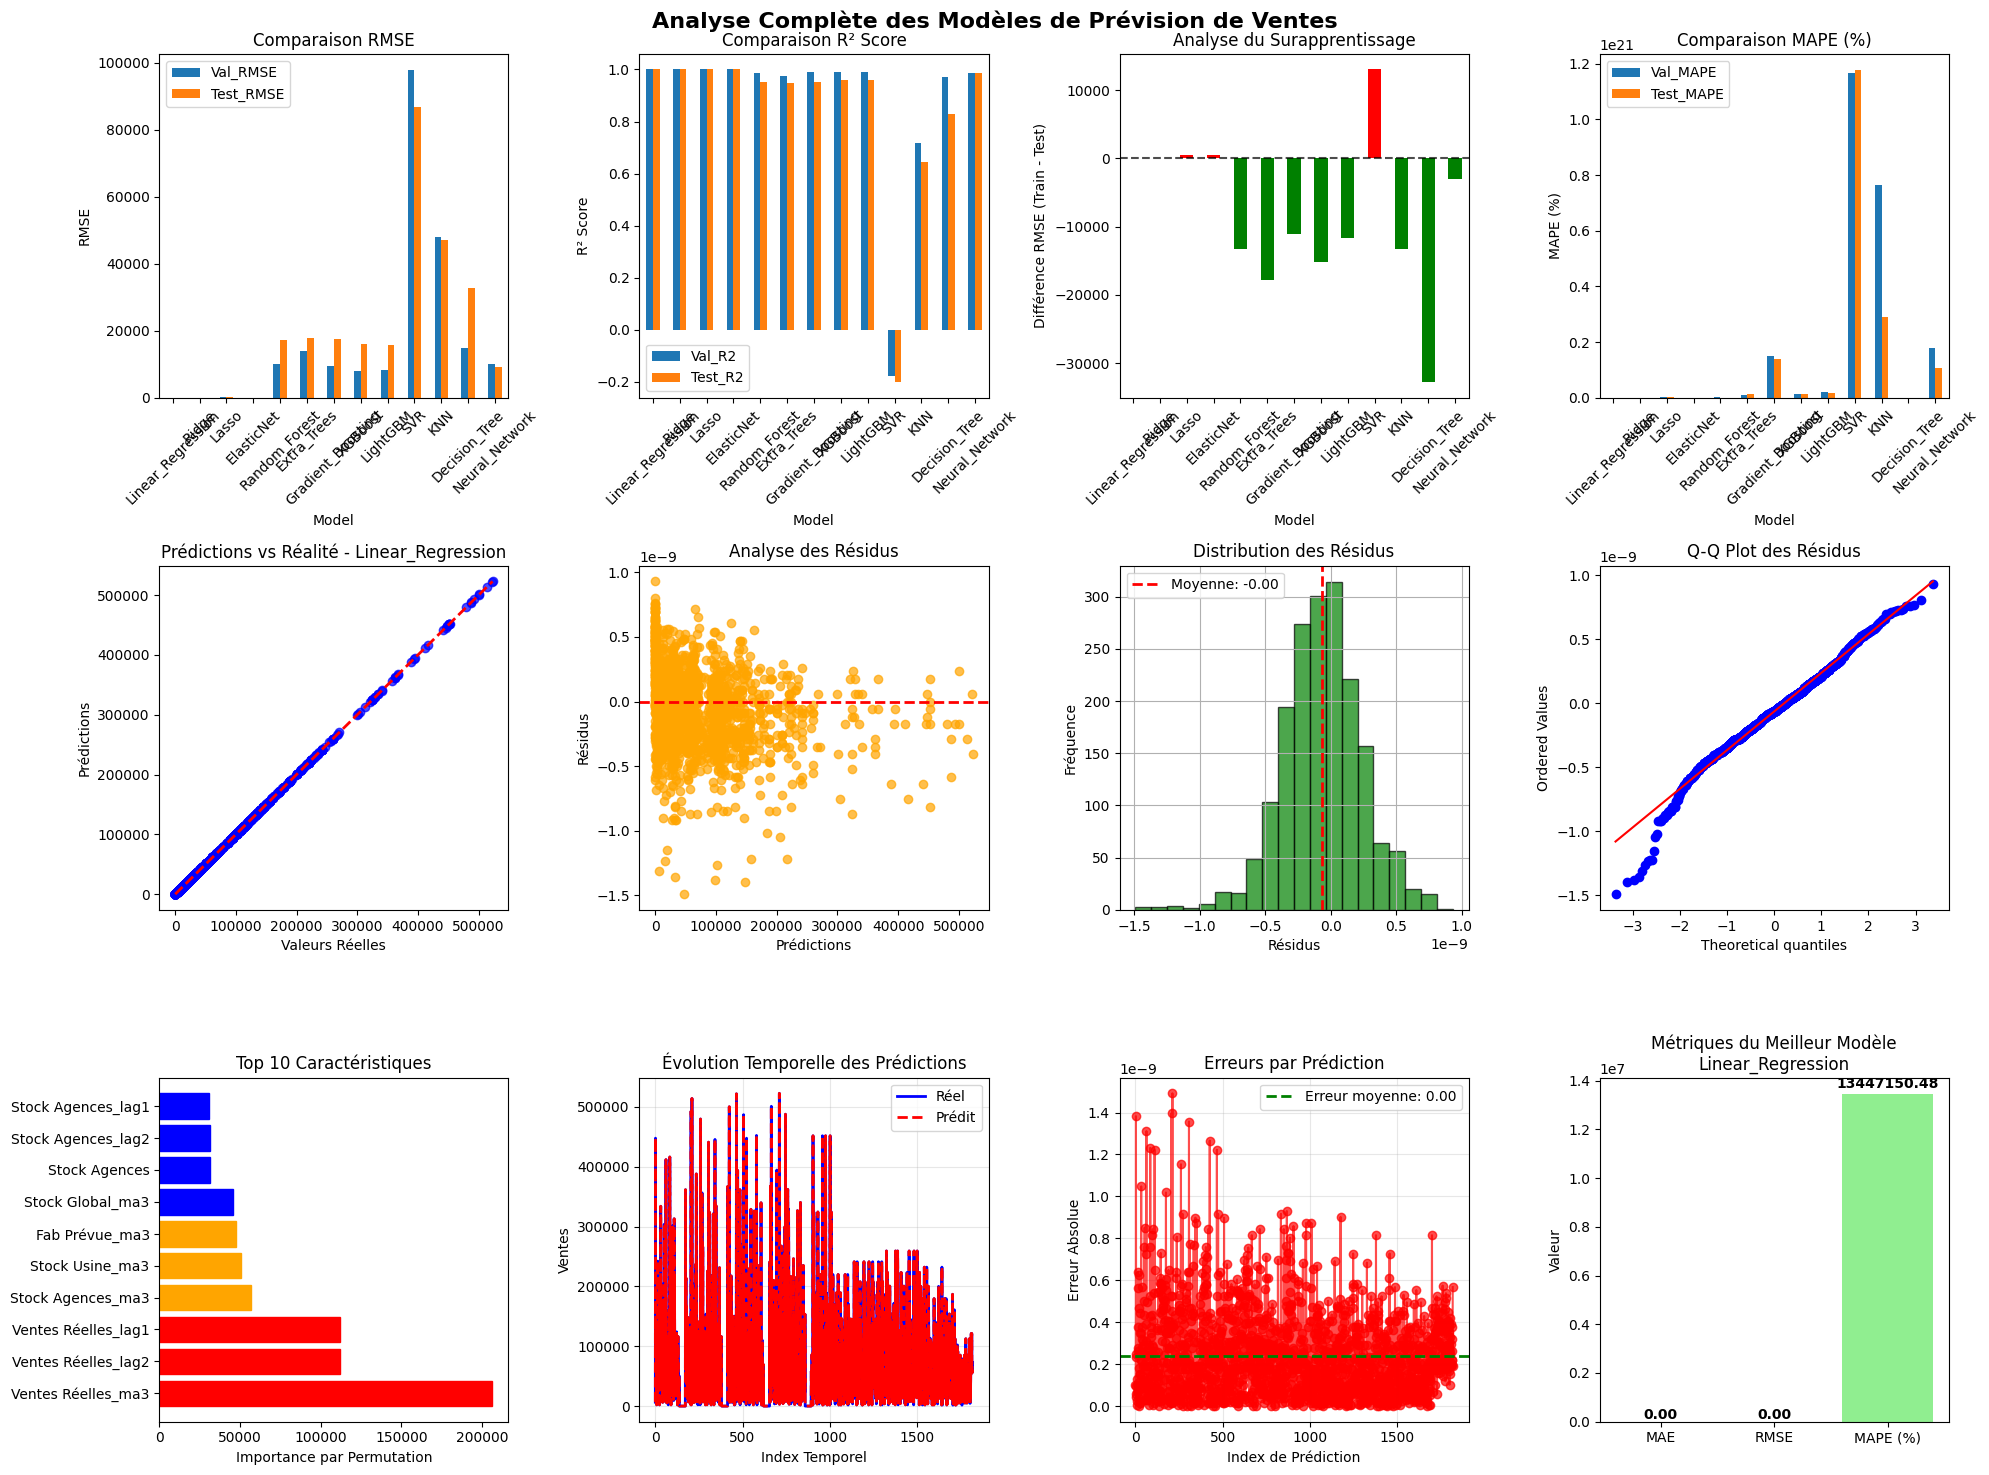

In [33]:
if __name__ == "__main__":
    print("🏭 SYSTÈME AVANCÉ DE PRÉVISION DE VENTES")
    print("=" * 45)
    print("Choisissez une option:")
    print("1. Démonstration avec données d'exemple")
    print("2. Utilisation avec vos vraies données")

    choice = input("Votre choix (1 ou 2): ")

    if choice == "1":
        # Démonstration
        results= demonstrate_forecasting_system()
        plt.show()

    elif choice == "2":
        # Utilisation avec vraies données
        print("\n📁 Chargement de vos données...")

        # Exemple d'utilisation avec un fichier CSV
        # data_path = "votre_fichier_de_donnees.csv"  # Remplacez par votre chemin

        # Si vous avez un DataFrame pandas déjà chargé:
        # results = run_complete_forecasting_pipeline(your_dataframe)

        print("Veuillez adapter le code pour charger vos données réelles.")
        print("Exemple:")
        print("data = pd.read_csv('votre_fichier.csv')")
        print("results = run_complete_forecasting_pipeline(data)")

    else:
        print("Choix non valide. Lancement de la démonstration...")
        results, prediction = demonstrate_forecasting_system()
        plt.show()